# Cyberbullying Classification

### 1. The degree of aggressivity & Negativity

### 2. Personnalization
    - Depency tree, establish the subject, object, complement, aux
    - Also, tell the (person 1st, 2nd, 3rd) of the subject and the object. 
    - Identify what are they accuse from 
    - Identify who’s being targeted (Lexicon or wordnet)
    - Established if the aux is directed to the object  (Establishing intention)
### 3. Harms inflicted and to who
    - Now, using the complement (output of dependency tree), we can map these to threats
    - We need wordnet to identify threat. (Actually better lexicon than word net)
    - To object refers to what category? race, nationality, religion, color, gender, 



Set your environment
- source spacy/bin/activate (Bash)
- get back to your base: deactivate (Bash)

You have to be in anaconda3 interpreter

# Import data

In [1]:
import numpy as np
import pandas as pd 
import os
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
import re
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from spacy import displacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import spacy
import nltk
nlp = spacy.load("en_core_web_sm")
import en_core_web_sm
nlp = en_core_web_sm.load()


In [33]:
macbook = ('/Users/philippebeliveau/Desktop/Notebook/Winter_2024/Text_mining/Git_MiningRepository/Text_miningProject/Notebook/cyberbullying_tweets.csv')

mac_mini = ('/Users/philippebeliveau/Desktop/Notebook_Jupyter_R/Winter_2024/Text_mining/Project/Text_miningProject/Notebook/cyberbullying_tweets.csv')

df = pd.read_csv(mac_mini)
df.head()
categories = df['cyberbullying_type'].unique()


In [34]:
# Initialize an empty dictionary to hold the tweets by category
tweets_by_category = {}

# Iterate over each category
for category in categories:
    # Filter the dataset for the current category
    category_tweets = df[df['cyberbullying_type'] == category]['tweet_text'].tolist()
    
    # Add the list of tweets to the dictionary
    tweets_by_category[category] = category_tweets

category = tweets_by_category['ethnicity'][100:120]

# Data preprocessing

In [43]:
# Filter 2000 tweets from each category
df = df.groupby('cyberbullying_type').apply(lambda x: x.sample(min(len(x), 2000), random_state=123)).reset_index(drop=True)

# Now you can work with 'sampled_df' which contains 2000 samples from each category
df.shape[0]

12000

In [44]:
import re

def clean_text(text):
    #removing hastags, links and specific symbol
    pattern=re.compile(r"(#[a-zA-Z0-9]+|@[a-zA-Z0-9]+|https?://\S+|www\.\S+|\S+\.[a-z]+|RT @|Ã°ÂÂÂ)")
    text = pattern.sub('', text)
    text = " ".join(text.split())
    
    return text

In [45]:
#cleaning of data
df['clean_data']=df['tweet_text'].apply(lambda x: clean_text(x))

# Part 2 - Critique vs Insult

## Current version

In [53]:
# With VADER
from nltk.sentiment.util import mark_negation
from nltk.corpus import sentiwordnet as swn

# Initialize lists to store data
analyzer = SentimentIntensityAnalyzer()
data = []

df_clean = df

for tweet in df_clean['clean_data']:
    # Analyze the tweet
    doc = nlp(tweet)

    # Extract adjectives, nouns, subjects and complements/conjunctions/root
    adjectives = [token.text for token in doc if token.pos_ == "ADJ"]
    nouns = [token.text for token in doc if token.pos_ == "NOUN"]
    subjects = [(token.text, token.morph.get('Person')) for token in doc if token.dep_ == "nsubj"]
    complements = [token.text for token in doc if token.dep_ in ("acomp", "conj", "ROOT")]

    # Extract children of ccomp or conj
    dep_children = []
    senti_sentiments = []
    textToken = []
    for token in doc:
        if token.dep_ in ("conj", 'ROOT', 'ccomp'):
            children = [child.text for child in token.children]
            dep_children.append(children)
            # Compute sentiment scores for each child and append to list
            senti_sentiments.extend([analyzer.polarity_scores(child)["compound"] for child in children])
        if token.pos_ in ("AUX", 'PROPN'): 
            child = [child.text for child in token.children]
            textToken.append(child)
        # if token.dep_ in ("acomp", 'advmod', 'amod',"appos", "coordination"): 
        #     text = token.text
        #     textToken.append(text)
    # Compute sum of sentiment scores for the children
    sum_senti_sentiments = sum(senti_sentiments)

    # Extract named entities and their types
    named_entities = [(ent.text, ent.label_) for ent in doc.ents]

    # Extract synonyms
    synonyms = []
    for token in doc:
        if token.pos_ in ("ADJ", "NOUN", 'ccomp'):
            for syn in wordnet.synsets(token.text):
                for lemma in syn.lemmas():
                    synonyms.append(lemma.name())

    # Create a polarity score
    sentiment_score = analyzer.polarity_scores(tweet)["compound"]
    synonyms_sentiment_score = analyzer.polarity_scores(" ".join(synonyms))["compound"]

    # Check if "?" is in the tweet
    has_question_mark = "?" in tweet

    # Mark negation in the tweet
    negated_tweet = " ".join(mark_negation(tweet.split()))

    # Check for discourse markers
    discourse_markers = ['say', 'claim']
    has_discourse_marker = any(marker in tweet for marker in discourse_markers)

    # Check if there is a 3rd person verb in the tweet
    has_third_person_verb = any(token.morph.get('Person') == '3' and token.pos_ == 'VERB' for token in doc)

    # Get SentiWordNet polarity scores
    senti_scores = []
    for token in doc:
        synsets = list(swn.senti_synsets(token.text))
        if synsets:
            senti_scores.append(synsets[0].pos_score() - synsets[0].neg_score())

    avg_senti_score = sum(senti_scores) / len(senti_scores) if senti_scores else 0

    # Append data to list
    data.append({
        "Tweet": tweet,
        "Has Question Mark": has_question_mark,
        "Negated Tweet": negated_tweet,
        "Has Discourse Marker": has_discourse_marker,
        "Tweet": tweet,
        "Adjectives": adjectives,
        "Nouns": nouns,
        "Subjects": subjects,
        "Complements": complements,
        "Dependency Children": dep_children,
        "Dependency Sentiment": sum_senti_sentiments,
        "Aux/pronouns dependence": textToken,
        "Named Entities": named_entities,
       # "Synonyms": synonyms,
        "Sentiment Score": sentiment_score,
        "Synonyms Sentiment Score": synonyms_sentiment_score,  
        "Has Third Person Verb": has_third_person_verb,
        "Average SentiWordNet Score": avg_senti_score,
    })

# Create DataFrame
df1 = pd.DataFrame(data)

In [54]:
def contains_person(subjects, person):
    person_list = [p for _, p_list in subjects for p in p_list]
    return str(person) in person_list

df1['Has 1st Person'] = df1['Subjects'].apply(lambda x: contains_person(x, 1))
df1['Has 2nd Person'] = df1['Subjects'].apply(lambda x: contains_person(x, 2))
df1['Has 3rd Person'] = df1['Subjects'].apply(lambda x: contains_person(x, 3))

df1['Word Count'] = df1['Tweet'].apply(lambda x: len(x.split()))
df1['Adjusted Vader score'] = df1.apply(lambda row: row['Dependency Sentiment'] / len(row['Dependency Children']) if len(row['Dependency Children']) != 0 else 0, axis=1)
#df1['Adjusted SentiWordScore'] = df1.apply(lambda row: row['Dependency Sentiment'] / len(row['Tweet']) if len(row['Tweet']) != 0 else 0, axis=1)
df1['Has Capital Word'] = df1['Tweet'].apply(lambda x: any(word.isupper() for word in x.split()))


### Save df

In [48]:
# Export csv
#df.to_csv('/Users/philippebeliveau/Library/Mobile Documents/com~apple~CloudDocs/_Bureau_/Master/Winter_2024/Text_mining/Project/Dataframe/Version2.csv')

In [49]:
# Import csv 
#df = pd.read_csv('/Users/philippebeliveau/Library/Mobile Documents/com~apple~CloudDocs/_Bureau_/Master/Winter_2024/Text_mining/Project/Dataframe/Version2.csv')

# Classification
## Rules
1. "Target identification" -> Identify if there is a target, Does it have a 2nd or 3rd person subject, and or Is the name entities is a PERSON or NORP. If that is true, then increase the threshold required to classify as an insult. 
2. "Absence of target" -> If the Entities are not speaking about a Person or NORP, and have no 2nd and 3rd person subject, then increase the required sentiment score. 
3. "Discourse or Insults?" -> Make a rule regarding Discourse marker. If a tweet shows more of a discourse,the threshold for the sentiment should be very high. Does the tweet as a question mark or a discourse marker such as ["but", "however", "on the other hand", "yet", "nevertheless", "although",
                     "while", "even though", "despite", "regardless", "rather", "instead",
                     "meanwhile", "in contrast", "conversely", "compared to", "on the contrary",
                     "besides", "furthermore", "moreover", "in addition", "additionally",
                     "further", "also", "next", "then", "afterward", "finally",
                     "therefore", "thus", "hence", "consequently", "as a result", "so",
                     "because", "since", "due to", "as long as", "provided that", "given that",
                     "for example", "for instance", "specifically", "in particular", "to illustrate",
                     "to clarify", "to explain", "in summary", "to sum up", "in conclusion",
                     "indeed", "certainly", "obviously", "clearly", "undoubtedly", "surely"]. 
4. "SentiWordScore" -> If the Adjusted SentiWordScore is smaller then -0.6, then classify it automatically as an Insults
5. "Expressiveness" -> If the tweets have row['Has Capital Word'] == True, then make the threshold of the sentiment lower. 
6. "Degree of Positiveness" -> If the general tweet is positive, such as row['Sentiment Score'] > 0.3 and row['Synonyms Sentiment Score'] > 0.2, make it more different to be classify as insult and increase the threshold of Adjusted SentiWordScore
7. "Age tweets?" -> If education_terms = ['school', 'schools', 'college', 'graduation']
    if any(term in str(word) for term in education_terms for word in row[['Nouns', 'Tweet']]):
        return 'Critique/Other'
8. "Description tweets" -> Tweets with name entities such as Percent, Quanity, Ordinal etc should have more difficult threshold to be classify as insults. 
Note, the score here refers to this one: Adjusted SentiWordScore

In [55]:
# 8 rules classification 
def classify(row):
    # Rule 1: Threshold for insult
    insult_threshold = -0.2  # Define your threshold here

    # Rule 2: Absence of target
    if not any(entity in ['PERSON', 'NORP'] for entity in row['Named Entities']) and not row['Has 2nd Person'] and not row['Has 3rd Person']:
        insult_threshold -= 0.2  # Adjust the threshold as needed

    # Rule 3: Discourse or Insults?
    discourse_markers = ["but", "however", "on the other hand", "yet", "nevertheless", "although",
                         "while", "even though", "despite", "regardless", "rather", "instead",
                         "meanwhile", "in contrast", "conversely", "compared to", "on the contrary",
                         "besides", "furthermore", "moreover", "in addition", "additionally",
                         "further", "also", "next", "then", "afterward", "finally",
                         "therefore", "thus", "hence", "consequently", "as a result", "so",
                         "because", "since", "due to", "as long as", "provided that", "given that",
                         "for example", "for instance", "specifically", "in particular", "to illustrate",
                         "to clarify", "to explain", "in summary", "to sum up", "in conclusion",
                         "indeed", "certainly", "obviously", "clearly", "undoubtedly", "surely"]
    if any(marker in row['Tweet'] for marker in discourse_markers):
        insult_threshold -= 0.4  # Adjust the threshold as needed

    # Rule 4: SentiWordScore
    if row['Adjusted SentiWordScore'] < insult_threshold:
        return 'Insults'

    # Rule 5: Expressiveness
    if row['Has Capital Word']:
        insult_threshold += 0.1  # Adjust the threshold as needed

    # Rule 6: Degree of Positiveness
    if row['Sentiment Score'] > 0.3 and row['Synonyms Sentiment Score'] > 0.2:
        insult_threshold -= 0.2  # Adjust the threshold as needed

    # Rule 7: Age tweets?
    education_terms = ['school', 'schools', 'college', 'graduation']
    if any(term in str(word) for term in education_terms for word in row[['Nouns', 'Tweet']]):
        return 'Critique/Other'

    # Rule 8: Description tweets
    if any(entity in ['PERCENT', 'QUANTITY', 'ORDINAL', 'TIME'] for entity in row['Named Entities']):
        insult_threshold -= 0.8  # Adjust the threshold as needed
        
    # Final classification
    if row['Adjusted SentiWordScore'] < insult_threshold:
        return 'Insults'
    
    else:
        return 'Critique/Other'

df1['Classification'] = df1.apply(classify, axis=1)

In [56]:
df1.loc[df1['Classification'] == 'Insults', 'Adjusted SentiWordScore'].mean()

-0.4669424204200452

# Evaluation

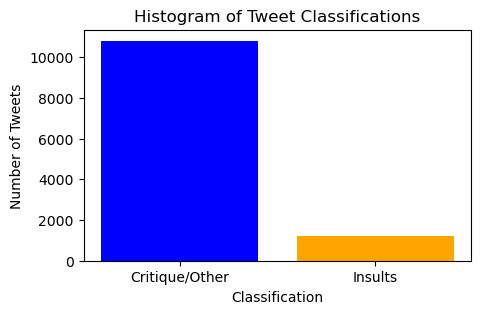

Critique/Other    10808
Insults            1192
Name: Classification, dtype: int64


In [57]:
import matplotlib.pyplot as plt

# Get counts
classification_counts = df1['Classification'].value_counts()

# Create histogram
plt.figure(figsize=(5, 3))
plt.bar(classification_counts.index, classification_counts.values, color=['blue', 'orange'])
plt.xlabel('Classification')
plt.ylabel('Number of Tweets')
plt.title('Histogram of Tweet Classifications')
plt.show()
print(classification_counts)

In [66]:
import pandas as pd

# Set max rows and columns
# Set max column width
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

df_insult = df1[df1['Classification'] == 'Insults']
df_critique = df1[df1['Classification'] == 'Critique/Other']
df1[['Tweet', 'Classification', 'Adjusted SentiWordScore', 'Subjects','Complements',"Dependency Children",
           'Aux/pronouns dependence','Has 1st Person', 'Has 2nd Person', 'Has 3rd Person', 'Named Entities', 'Has Discourse Marker', 
           'Has Question Mark', 'Has Third Person Verb', 'Adjectives']].sample(75, random_state=123)

# Per tweet 
#pd.DataFrame([df1.loc[573, ['Tweet',  'Classification', 'Adjusted SentiWordScore', 'Subjects','Complements',"Dependency Children", 'Aux/pronouns dependence','Has 1st Person', 'Has 2nd Person', 'Has 3rd Person', 'Named Entities', 'Has Discourse Marker', 'Has Question Mark', 'Has Third Person Verb', 'Adjectives']]])

In [68]:
#df_insult.to_csv('/Users/philippebeliveau/Library/Mobile Documents/com~apple~CloudDocs/_Bureau_/Master/Winter_2024/Text_mining/Project/Dataframe/Insults.csv')
#df_final.to_csv('/Users/philippebeliveau/Library/Mobile Documents/com~apple~CloudDocs/_Bureau_/Master/Winter_2024/Text_mining/Project/Dataframe/Final.csv')
#df_critique.to_csv('/Users/philippebeliveau/Library/Mobile Documents/com~apple~CloudDocs/_Bureau_/Master/Winter_2024/Text_mining/Project/Dataframe/Critique.csv')